In [1]:
import openmm
import openmm.app
import numpy as np
import torch
import mdtraj as md
import ot
import os
import MDAnalysis
import matplotlib.pyplot as plt
from bgflow import MeanFreeNormalDistribution, OpenMMBridge, OpenMMEnergy
from bgflow.utils import distance_vectors, as_numpy
import sys
sys.path.append('../')
sys.path.append('../BoltzNCE/')
from infer_aa2 import fix_chirality

/net/galaxy/home/koes/rishal/.conda/envs/BoltzNCE/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with 

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
#test_dipeptides=['AC','ET','GN','IM','KS','NY','NF']
test_dipeptide='AC'

In [4]:
def calc_energy_w2(gen_energies, holdout_energies,prefix=''):
    """Calcualate and log energy and torsion w2 distance 

    Args:
        gen_energies (np list): tensor of generated samples energies
        holdout_energies (np list): tenosr of holdout sample energies, must be same shape and size as gen samples
    """
    
    
    
    # flatten both to 1-D
    
    gen_energies = gen_energies.ravel()
    holdout_energies = holdout_energies.ravel()

    # sort them
    # gen_energies_sorted = np.sort(gen_energies)
    # holdout_energies_sorted = np.sort(holdout_energies)
    loss = ot.emd2_1d(gen_energies,holdout_energies,metric = "sqeuclidean")

    # # compute MSE of the sorted values = W2^2
    # w2_squared = np.mean((gen_energies_sorted - holdout_energies_sorted)**2)

    # # take sqrt to get W2
    # W2 = np.sqrt(w2_squared)
    
    # if you want to log to wandb (scalar)
    return np.sqrt(loss)

def calc_torsion_w2(gen_angles,holdout_angles, prefix=''):
    """calculates OT w2 Torsion angles 

    Args:
        gen_angles (np list ): np array of sidechain angles 
        holdout_angles (_type_): np array of sidechain angles
    """
    dist = np.expand_dims(gen_angles,0) - np.expand_dims(holdout_angles,1)
    dist = np.sum((dist % np.pi)**2,axis = -1)
    # dist = np.sqrt(dist)
    a, b = ot.unif(gen_angles.shape[0]), ot.unif(gen_angles.shape[0])
    W,log = ot.emd2(a,b,dist,log = True, numItermax=1e9) # uniform weights as input
    # w2_circle = ot.wasserstein_circle(gen_angles, holdout_angles, p=2)
    W = np.sqrt(W)
    # print(f"Angles W2 distance: {w2_circle}")
    
    # w2_circle = ot.wasserstein_circle(gen_angles, holdout_angles, p=2)
    return W

In [ ]:
def calculate_w2_distances(phis,psis,phis_data,psis_data,log_w_np,energies,energies_data,prefix=''):

    energies_w2_proposal_list = []
    angles_w2_proposal_list = []
    energies_w2_reweighted_list = []
    angles_w2_reweighted_list = []
    for i in range(1):
        #subsample 10000 samples from data
        if len(phis_data)>10000:
            idxs = np.random.choice(len(phis_data), 10000, replace=False)
            phis_gt = phis_data[idxs]
            psis_gt = psis_data[idxs]
            angles_gt = np.concatenate([phis_gt[:, None], psis_gt[:, None]], axis=-1)
        if len(energies_data)>10000:
            idxs = np.random.choice(len(energies_data), 10000, replace=False)    
            energies_gt = energies_data[idxs]
        
        if len(phis)>10000:
            idxs = np.random.choice(len(phis), 10000, replace=False)
            phis_proposal = phis[idxs]
            psis_proposal = psis[idxs]
            angles_proposal = np.concatenate([phis_proposal[:, None], psis_proposal[:, None]], axis=-1)
        if len(energies)>10000:
            idxs = np.random.choice(len(energies), 10000, replace=False)
            energies_proposal = energies[idxs]


        #subsample 10000 samples from with log_w_np weights
        if len(phis)>10000:
            idxs = np.random.choice(len(phis), 10000, replace=True, p=np.exp(log_w_np[:,0])/np.sum(np.exp(log_w_np[:,0])))
            phis_reweighted = phis[idxs]
            psis_reweighted = psis[idxs]
            angles_reweighted = np.concatenate([phis_reweighted[:, None], psis_reweighted[:, None]], axis=-1)
        if len(energies)>10000:
            idxs = np.random.choice(len(energies), 10000, replace=True, p=np.exp(log_w_np[:,0])/np.sum(np.exp(log_w_np[:,0])))
            energies_reweighted = energies[idxs]
        energy_w2 = calc_energy_w2(energies_proposal, energies_gt,prefix=prefix)
        energies_w2_proposal_list.append(energy_w2)
        angles_w2= calc_torsion_w2(angles_proposal, angles_gt,prefix=prefix)
        angles_w2_proposal_list.append(angles_w2)
        energy_w2_reweighted = calc_energy_w2(energies_reweighted, energies_gt,prefix=prefix)
        energies_w2_reweighted_list.append(energy_w2_reweighted)
        angles_w2_reweighted = calc_torsion_w2(angles_reweighted, angles_gt,prefix=prefix)
        angles_w2_reweighted_list.append(angles_w2_reweighted)
    energies_w2_proposal_mean = np.mean(energies_w2_proposal_list)
    angles_w2_proposal_mean = np.mean(angles_w2_proposal_list)
    energies_w2_proposal_std = np.std(energies_w2_proposal_list)
    angles_w2_proposal_std = np.std(angles_w2_proposal_list)
    energies_w2_reweighted_mean = np.mean(energies_w2_reweighted_list)
    angles_w2_reweighted_mean = np.mean(angles_w2_reweighted_list)
    print(prefix + "Energies W2 distance proposal mean:", energies_w2_proposal_mean)
    print(prefix + "Energies W2 distance proposal std:", energies_w2_proposal_std)
    print(prefix + "Angles W2 distance proposal mean:", angles_w2_proposal_mean)
    print(prefix + "Angles W2 distance proposal std:", angles_w2_proposal_std)
    print(prefix + "Energies W2 distance reweighted mean:", energies_w2_reweighted_mean)
    print(prefix + "Angles W2 distance reweighted mean:", angles_w2_reweighted_mean)
    print(prefix + "Energies W2 distance reweighted std:", np.std(energies_w2_reweighted_list))
    print(prefix + "Angles W2 distance reweighted std:", np.std(angles_w2_reweighted_list))
    return energies_w2_proposal_mean, angles_w2_proposal_mean,energies_w2_reweighted_mean,angles_w2_reweighted_mean

In [2]:
def compute_free_energy_difference(phis, log_w_np, prefix=''):
    left = 0.
    right = 2

    hist, edges = np.histogram(phis, bins=100, density=True,weights=np.exp(log_w_np[:,0]))
    centers = 0.5*(edges[1:] + edges[:-1])
    centers_pos = (centers > left) & (centers < right)
    
    free_energy_difference = -np.log(hist[centers_pos].sum()/
    hist[~centers_pos].sum())
    print(prefix + " Free energy difference:", free_energy_difference)
    return free_energy_difference

In [4]:
pdb_path=f'../data/2AA-1-huge/test/{test_dipeptide}-traj-state0.pdb'
topology = md.load(pdb_path).topology
test_md_xyz = np.load(f'../data/2AA-1-huge/test/{test_dipeptide}-traj-arrays.npz')
test_md=md.Trajectory(test_md_xyz['positions'], topology=topology)
pred_md = np.load(f'../generated/{test_dipeptide}_ebm_100k_{test_dipeptide}_potential_samples_dict_epoch_31_threshold_0.2.npz')
pred_md_xyz = pred_md['samples']
pred_md_energies = pred_md['energies']
pred_md_weights = pred_md['log_w']

NameError: name 'test_dipeptide' is not defined

In [8]:
print(f"Test MD shape: {test_md_xyz['positions'].shape}")
print(f"Pred MD shape: {pred_md_xyz.shape}")
print(f"pred_md_energies shape: {pred_md_energies.shape}")
print(f"pred_md_weights shape: {pred_md_weights.shape}")
pred_md_xyz = pred_md_xyz[:pred_md_energies.shape[0]]
print(f"pred_md_xyz shape: {pred_md_xyz.shape}")

Test MD shape: (200000, 24, 3)
Pred MD shape: (89376, 24, 3)
pred_md_energies shape: (89198, 1)
pred_md_weights shape: (89198, 1)
pred_md_xyz shape: (89198, 24, 3)


In [15]:
test_xyz = test_md.xyz[test_md_xyz['step'] % 10000 == 0][:190000]
pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)


In [10]:
pdb = openmm.app.PDBFile(pdb_path)
forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")

system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
        nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))
classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(test_xyz)[::10].reshape(-1, test_xyz.shape[-1]*test_xyz.shape[-2])))

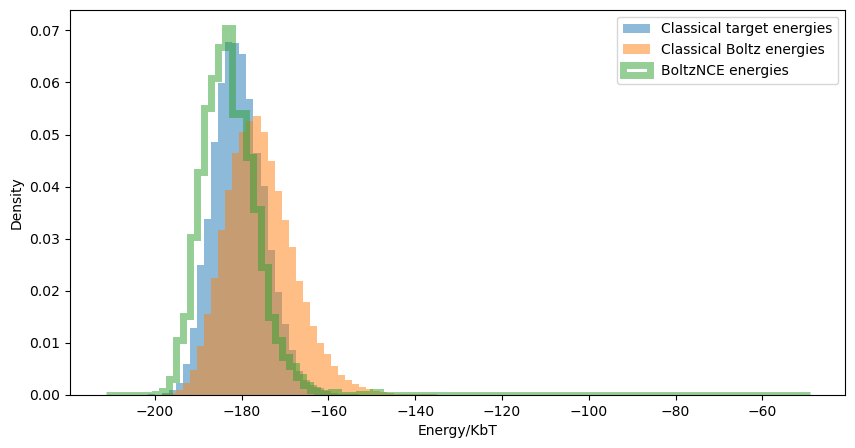

In [13]:
plt.figure(figsize=(10, 5))
range_limits = (classical_target_energies.min()-10,classical_target_energies.max()+100)
plt.hist(classical_target_energies, bins=100, alpha=0.5,density=True,range=range_limits, label='Classical target energies')
plt.hist(pred_md_energies, bins=100, alpha=0.5,density=True,range=range_limits, label='Classical Boltz energies')
plt.hist(pred_md_energies, bins=100, alpha=0.5,density=True,range=range_limits,weights=np.exp(pred_md_weights),histtype='step', linewidth=5, label='BoltzNCE energies')
plt.xlabel('Energy/KbT')
plt.ylabel('Density')
plt.legend()
plt.show()

In [18]:
phis_traj=md.compute_phi(pred_md_traj)[1].flatten()
phis_test=md.compute_phi(test_md)[1].flatten()
fed_traj=compute_free_energy_difference(phis_traj, pred_md_weights, prefix='Trajectory')
fed_test=compute_free_energy_difference(phis_test, np.zeros((phis_test.shape[0],1)), prefix='Test')
estimation_error=np.abs(fed_traj-fed_test)
print("Estimation error:", estimation_error)

Trajectory Free energy difference: 3.301312120114939
Test Free energy difference: 3.6647931810937897
Estimation error: 0.3634810609788506


In [19]:
psis_traj=md.compute_psi(pred_md_traj)[1].flatten()
psis_test=md.compute_psi(test_md)[1].flatten()

In [24]:
calculate_w2_distances(phis_traj, psis_traj, phis_test, psis_test, pred_md_weights, pred_md_energies, classical_target_energies, prefix='Classical MD ')

Classical MD Energies W2 distance proposal mean: 5.3517376845575875
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.198418282047171
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 1.1868513403487473
Classical MD Angles W2 distance reweighted mean: 0.47249063945111497
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


(5.3517376845575875,
 1.198418282047171,
 1.1868513403487473,
 0.47249063945111497)

In [36]:
def compute_dipeptide_metrics(test_dipeptide):
    pdb_path=f'../data/2AA-1-huge/test/{test_dipeptide}-traj-state0.pdb'
    topology = md.load(pdb_path).topology
    test_md_xyz = np.load(f'../data/2AA-1-huge/test/{test_dipeptide}-traj-arrays.npz')
    test_md=md.Trajectory(test_md_xyz['positions'], topology=topology)
    pred_md = np.load(f'../generated/{test_dipeptide}_ebm_100k_{test_dipeptide}_potential_samples_dict_epoch_91_threshold_0.2.npz')
    pred_md_xyz = pred_md['samples']
    pred_md_energies = pred_md['energies']
    pred_md_weights = pred_md['log_w']
    pred_md_xyz = pred_md_xyz[:pred_md_energies.shape[0]]
    test_xyz = test_md.xyz[test_md_xyz['step'] % 10000 == 0][:190000]
    pred_md_traj = md.Trajectory(pred_md_xyz, topology=topology)
    pdb = openmm.app.PDBFile(pdb_path)
    forcefield = openmm.app.ForceField("amber14-all.xml", "implicit/obc1.xml")

    system = forcefield.createSystem(pdb.topology, nonbondedMethod=openmm.app.CutoffNonPeriodic,
            nonbondedCutoff=2.0*openmm.unit.nanometer, constraints=None)
    integrator = openmm.LangevinMiddleIntegrator(310*openmm.unit.kelvin, 0.3/openmm.unit.picosecond, 0.5*openmm.unit.femtosecond)
    openmm_energy = OpenMMEnergy(bridge=OpenMMBridge(system, integrator, platform_name="CUDA"))
    classical_target_energies = as_numpy(openmm_energy.energy(torch.from_numpy(test_xyz)[::10].reshape(-1, test_xyz.shape[-1]*test_xyz.shape[-2])))
    phis_traj=md.compute_phi(pred_md_traj)[1].flatten()
    phis_test=md.compute_phi(test_md)[1].flatten()
    fed_traj=compute_free_energy_difference(phis_traj, pred_md_weights, prefix='Trajectory')
    fed_test=compute_free_energy_difference(phis_test, np.zeros((phis_test.shape[0],1)), prefix='Test')
    estimation_error=np.abs(fed_traj-fed_test)
    print("Estimation error:", estimation_error)
    psis_traj=md.compute_psi(pred_md_traj)[1].flatten()
    psis_test=md.compute_psi(test_md)[1].flatten()
    energies_w2_proposal_mean,angles_w2_proposal_mean,energies_w2_reweighted_mean,angles_w2_reweighted_mean=calculate_w2_distances(phis_traj, psis_traj, phis_test, psis_test, pred_md_weights, pred_md_energies, classical_target_energies, prefix='Classical MD ')
    return estimation_error, energies_w2_proposal_mean, angles_w2_proposal_mean, energies_w2_reweighted_mean, angles_w2_reweighted_mean


In [37]:
energies_w2_list = []
angles_w2_list = []
energies_w2_reweighted_list = []
angles_w2_reweighted_list = []
estimation_error_list = []
for test_dipeptide in ['AC','ET','GN','IM','KS','NY','NF']:
    print(f"Calculating metrics for {test_dipeptide}")
    estimation_error,energies_w2, angles_w2,energies_w2_reweighted, angles_w2_reweighted = compute_dipeptide_metrics(test_dipeptide)
    energies_w2_list.append(energies_w2)
    angles_w2_list.append(angles_w2)
    energies_w2_reweighted_list.append(energies_w2_reweighted)
    angles_w2_reweighted_list.append(angles_w2_reweighted)
    estimation_error_list.append(estimation_error)
    print("\n" + "="*50 + "\n")
print("Energies W2 mean:", np.mean(energies_w2_list))
print("Energies W2 std:", np.std(energies_w2_list))
print("Angles W2 mean:", np.mean(angles_w2_list))
print("Angles W2 std:", np.std(angles_w2_list))
print("Energies W2 reweighted mean:", np.mean(energies_w2_reweighted_list))
print("Energies W2 reweighted std:", np.std(energies_w2_reweighted_list))
print("Angles W2 reweighted mean:", np.mean(angles_w2_reweighted_list))
print("Angles W2 reweighted std:", np.std(angles_w2_reweighted_list))
print("Estimation error mean:", np.mean(estimation_error_list))
print("Estimation error std:", np.std(estimation_error_list))

Calculating metrics for AC
Trajectory Free energy difference: 3.495024875175123
Test Free energy difference: 3.6647931810937897
Estimation error: 0.16976830591866676
Classical MD Energies W2 distance proposal mean: 5.263175149762673
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 1.205544872047646
Classical MD Angles W2 distance proposal std: 0.0
Classical MD Energies W2 distance reweighted mean: 0.6300623905329094
Classical MD Angles W2 distance reweighted mean: 0.5813788149261926
Classical MD Energies W2 distance reweighted std: 0.0
Classical MD Angles W2 distance reweighted std: 0.0


Calculating metrics for ET
Trajectory Free energy difference: 4.566874380526321
Test Free energy difference: 4.113020701645649
Estimation error: 0.4538536788806722
Classical MD Energies W2 distance proposal mean: 11.49854788017834
Classical MD Energies W2 distance proposal std: 0.0
Classical MD Angles W2 distance proposal mean: 0.8769307916760025
Class